# Overview

## Setup

We require the following setup for using gemeni model:
1. https://cloud.google.com/docs/authentication/set-up-adc-local-dev-environment
2. https://cloud.google.com/docs/authentication/application-default-credentials#GAC

also need to enable billing etc to enable embeddings

In [36]:
from langchain_google_vertexai import ChatVertexAI
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_chroma import Chroma

llm = ChatVertexAI(model="gemini-1.0-pro")
embeddings = VertexAIEmbeddings(model_name="text-embedding-004")
vector_store = Chroma(embedding_function=embeddings)

In [37]:
import bs4
import uuid
from typing import Annotated, Sequence
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, BaseMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START, END, StateGraph, MessagesState
from typing_extensions import List, TypedDict
from IPython.display import Image, display

USER_AGENT environment variable not set, consider setting it to identify your requests.


## QA RAG model
see: https://python.langchain.com/docs/tutorials/rag/

### Pipeline for ingesting data from a source and indexing it (by semantic search for our case)

1. Load data with a data loader
2. Break large documents into smaller chunks with text splitters to fit into model's finite context window
3. Use vector store and embeddings model to store and index the splits

In [38]:
# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/", # general llm agent blog for the curious
               # help llm make sense of functions
                "https://xrpl-py.readthedocs.io/en/stable/source/snippets.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.models.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.wallet.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.clients.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.transaction.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.ledger.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.core.addresscodec.html",
                "https://xrpl-py.readthedocs.io/en/stable/source/xrpl.utils.html",
                # context for answering questions related to the XRPL
                "https://xrpl.org/docs/introduction/what-is-the-xrp-ledger",
                "https://xrpl.org/docs/introduction/what-is-xrp",
                "https://xrpl.org/docs/introduction/crypto-wallets",
                "https://xrpl.org/docs/introduction/transactions-and-requests",
                # context for answering questions related to the THENA protocol
               "https://docs.thena.fi/thena?ref=bnbchain.ghost.io",
               "https://docs.thena.fi/thena/the-onboarding",
               "https://docs.thena.fi/thena/the-spot-dex/swap-guide",
               "https://docs.thena.fi/thena/the-spot-dex/limit-order",
               "https://docs.thena.fi/thena/the-liquidity-pools/introduction-to-fusion",
               "https://docs.thena.fi/thena/the-liquidity-pools/liquidity-pools-typology",
               "https://docs.thena.fi/thena/the-liquidity-pools/earn-the",
               "https://docs.thena.fi/thena/the-liquidity-pools/earn-trading-fees",
                ),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer( 
            # Only keep post title, headers, and content from the full HTML.
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

### Retrieval and generation chain for taking user query at run time and retrieving data from index

1. Use a retriever to match against user query. Extending this to a tool allows models to rewrite user queries into more effective search queries. This also gives model a choice to either respond immediately or do RAG.
2. ChatModel / LLM produces answer from prompt (which takes in user query and retrieved data)

In [39]:

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(
        query, 
        k=2
    )
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

## Agent
Now the control flow is defined by the reasoning capabilities of LLMs. Using agents allows you to offload additional discretion over the retrieval process. Although their behavior is less predictable than the above "chain", they are able to execute multiple retrieval steps in service of a query, or iterate on a single search.

In [40]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver() # support multiple conversational turns

In [41]:
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

websearch = TavilySearchResults(max_results=3)

# mem_agent = create_react_agent(llm, [retrieve, websearch], checkpointer=memory) 
# display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [42]:
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate

def create_tool_agent(llm: ChatVertexAI, tools: list, system_prompt: str):
    """Helper function to create agents with custom tools and system prompt
    Args:
        llm (ChatVertexAI): LLM for the agent
        tools (list): list of tools the agent will use
        system_prompt (str): text describing specific agent purpose

    Returns:
        executor (AgentExecutor): Runnable for the agent created.
    """
    
    # Each worker node will be given a name and some tools.
    
    system_prompt_template = PromptTemplate(

                template= system_prompt + """
                ONLY respond to the part of query relevant to your purpose.
                IGNORE tasks you can't complete. 
                Use the following context to answer your query 
                if available: \n {agent_history} \n
                """,
                input_variables=["agent_history"],
            )

    #define system message
    system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

    prompt = ChatPromptTemplate.from_messages(
        [system_message_prompt,
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_tool_calling_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, 
                return_intermediate_steps= True, verbose = False)
    return executor

## XRPL DEX Setup for agent tooling

In [43]:
from xrpl.clients import JsonRpcClient
from xrpl.clients import WebsocketClient
from xrpl.wallet import generate_faucet_wallet
from xrpl.models.transactions import Payment
from xrpl.transaction import submit_and_wait, autofill_and_sign
from xrpl.models.requests.account_info import AccountInfo
from xrpl.models.transactions import OfferCreate, OfferCancel
from xrpl.models.currencies import IssuedCurrency, XRP
from xrpl.models.requests import (

    BookOffers,
)
from xrpl.utils import (
    xrp_to_drops,
)

import pprint
import requests
from decimal import Decimal

In [51]:
@tool(response_format="content_and_artifact")
def get_json_rpc_client():
    """Create a JSON-RPC client for the XRP Ledger."""
    return JsonRpcClient("https://s.altnet.rippletest.net:51234/")

@tool(response_format="content_and_artifact")
def get_websocket_client():
    """Create a WebSocket client for the XRP Ledger."""
    return WebsocketClient("wss://s.altnet.rippletest.net:51233")

@tool(response_format="content_and_artifact")
def generate_wallet(client):
    """Generate a new wallet using the XRP Ledger."""
    return generate_faucet_wallet(client, debug=False)

@tool(response_format="content_and_artifact")
def sign_and_submit_payment_txn(client, wallet, destination, amount):
    """Sign and submit a payment transaction to the XRP Ledger."""
    payment = Payment(
        account=wallet.classic_address,
        amount=xrp_to_drops(amount),
        destination=destination
    )
    response = submit_and_wait(payment, client, wallet)
    return response

@tool(response_format="content_and_artifact")
def get_account_info(client, address):
    """Get account information from the XRP Ledger."""
    info = AccountInfo(
        account=address,
        edger_index="validated",
        strict=True,
    )
    response = client.request(info)
    return response
    

### Trading specific functions
# https://xrpl.org/docs/tutorials/how-tos/use-tokens/trade-in-the-decentralized-exchange#interactive-lookupoffers
@tool(response_format="content_and_artifact")
def offer_lookup(wallet, client, currency_code_want, currency_issuer_want, want_value, currency_code_spend, currency_issuer_spend, spend_value, ledger_idx="current"):
    """lookup offers on the XRP Ledger."""
    
    we_want = {
        "currency": IssuedCurrency(
            currency=currency_code_want,
            issuer=currency_issuer_want
        ),
        "value": want_value
    }

    we_spend = {
        "currency": IssuedCurrency(
            currency=currency_code_spend,
            issuer=currency_issuer_spend
        )
    }

    proposed_quality = Decimal(we_spend["value"]) / Decimal(we_want["value"])

    orderbook_info = client.request(BookOffers(
        taker=wallet.classic_address,
        ledger_index=ledger_idx,
        taker_gets=we_want["currency"],
        taker_pays=we_spend["currency"],
        limit=10,
    ))

    offers = orderbook_info.result.get("offers", [])
    want_amount = Decimal(we_want["value"])
    running_total = Decimal(0)
    messages = []

    if len(offers) == 0:
        messages.append("No Offers in the matching book. Offer probably won't execute immediately.")
    else:
        for o in offers:
            if Decimal(o["quality"]) <= proposed_quality:
                messages.append(f"Matching Offer found, funded with {o.get('owner_funds')} {we_want['currency']}")
                running_total += Decimal(o.get("owner_funds", Decimal(0)))
                if running_total >= want_amount:
                    messages.append("Full Offer will probably fill")
                    break
            else:
                messages.append("Remaining orders too expensive.")
                break

        messages.append(f"Total matched: {min(running_total, want_amount)} {we_want['currency']}")
        if 0 < running_total < want_amount:
            messages.append(f"Remaining {want_amount - running_total} {we_want['currency']} would probably be placed on top of the order book.")

    if running_total == 0:
        messages.append("Requesting second orderbook information...")
        orderbook2_info = client.request(
            BookOffers(
                taker=wallet.address,
                ledger_index="current",
                taker_gets=we_spend["currency"],
                taker_pays=we_want["currency"],
                limit=10,
            )
        )
        messages.append(f"Orderbook2:\n{pprint.pformat(orderbook2_info.result)}")

        offered_quality = Decimal(we_want["value"]) / Decimal(we_spend["value"])

        tally_currency = we_spend["currency"]
        if isinstance(tally_currency, XRP):
            tally_currency = f"drops of {tally_currency}"

        offers2 = orderbook2_info.result.get("offers", [])
        running_total2 = Decimal(0)
        if len(offers2) == 0:
            messages.append("No similar Offers in the book. Ours would be the first.")
        else:
            for o in offers2:
                if Decimal(o["quality"]) <= offered_quality:
                    messages.append(f"Existing offer found, funded with {o.get('owner_funds')} {tally_currency}")
                    running_total2 += Decimal(o.get("owner_funds", Decimal(0)))
                else:
                    messages.append("Remaining orders are below where ours would be placed.")
                    break

            messages.append(f"Our Offer would be placed below at least {running_total2} {tally_currency}")
            if 0 < running_total2 < want_amount:
                messages.append(f"Remaining {want_amount - running_total2} {tally_currency} will probably be placed on top of the order book.")

    return messages


# https://xrpl-py.readthedocs.io/en/stable/source/xrpl.models.transactions.html -> look for OfferCreate and OfferCancel
@tool(response_format="content_and_artifact")
def create_offer(wallet, client, currency_code_want, currency_issuer_want, want_value, currency_code_spend, currency_issuer_spend, spend_value):
    """Create an offer to trade on the XRP Ledger. Returns True if successful."""
    we_want = {
        "currency": IssuedCurrency(
            currency=currency_code_want,
            issuer=currency_issuer_want
        ),
        "value": want_value
    }

    we_spend = {
        "currency": IssuedCurrency(
            currency=currency_code_spend,
            issuer=currency_issuer_spend
        )
    }
    
    tx = OfferCreate(
        account=wallet.address,
            taker_gets=we_spend["value"],
            taker_pays=we_want["currency"].to_amount(we_want["value"]),
    )

    signed_tx = autofill_and_sign(tx, client, wallet)

    result = submit_and_wait(signed_tx, client)
    return result.is_successful()

# todo: implement cancel_offer function

# meta info api for querying exchanges and tokens
@tool(response_format="content_and_artifact")
def query_token_list(): # improvement: write to persistent storage and update every 24 hours
    """Query a list of tokens from the XRPL META API using http. Get back response as JSON. 
    Useful for getting individual token information needed for further queries."""
    response = requests.get("https://s1.xrplmeta.org/tokens")
    return response.json()

@tool(response_format="content_and_artifact") 
def query_token_info(token_currency: str, token_issuer: str):
    """
    Query token information from the XRPL META API using http. Get back response as JSON.
    Useful for getting links which provide more fundamental information about the token,
    as well as inherent properties of the token such as trust level.
    """
    token_identifier = f"{token_currency}:{token_issuer}"
    response = requests.get(f"https://s1.xrplmeta.org/token/{token_identifier}")
    return response.json()

## Continuation of agent prompts

In [52]:
sentiment_prompt = """ You are a assistant for performing research on market sentiment of a cryto asset.
        You are to gauge whether the sentiment is positive, negative or neutral based on news and statements
        made by influential sources in the cryptocurrency space. Also, weigh the sentiment based on the profile of the source.
        For example, a statement from a well-known cryptocurrency influencer may have more weight than a random twitter user with less than average number of followers.
        You must also take into account of whether the opinion is based on facts or speculation, and if the source has a history of being accurate.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

sentiment_agent = create_tool_agent(llm=llm, tools = [retrieve, websearch], # todo: add twitter, governance, news tools
              system_prompt = sentiment_prompt)

risk_prompt = """ You are a assistant for performing risk analysis and compliance on a crypto asset.
        You are to assess the risk of investing in a cryptocurrency based on the information available.
        You must consider the technology behind the cryptocurrency, the team behind the project, the market conditions, and the regulatory environment.
        Also, you will assess if this project satisfies regulatory requirements and if it is compliant with the law.
        Use your tools to complete requests. If you do not have a tool to
       complete the request, say so. """

risk_agent = create_tool_agent(llm=llm, tools = [retrieve, websearch], 
                    system_prompt = risk_prompt)


thena_api_prompt = """ You are an assistant for performing action such as querying user wallet status, trading, swapping and liquidity provision to THENA blockchain ecosystem based on the user's request if any.
        Use your tools to complete requests. If you do not have a tool to
       complete the request, say so. """

thena_api_agent = create_tool_agent(llm=llm, tools = [], 
                    system_prompt = thena_api_prompt)


xrpl_api_prompt = """ You are an assistant for performing action such as generating testnet wallet, querying user wallet status, trading, swapping and liquidity provision to Ripple Ledger (XRPL) blockchain ecosystem based on the user's request if any.
        Use your tools to complete requests. 
        If you need more information to call tools, ask for it and guide the user to knowing what tools you have.
        If you do not have a tool to
       complete the request, say so. """


xrpl_api_tools = [retrieve, websearch, get_json_rpc_client, get_websocket_client, generate_wallet, sign_and_submit_payment_txn, get_account_info, offer_lookup, create_offer, query_token_list, query_token_info]
xrpl_api_agent = create_tool_agent(llm=llm, tools = xrpl_api_tools, # todo: tools for staking, LPing, swapping etc
        system_prompt = xrpl_api_prompt)

In [53]:
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

system_prompt_template = PromptTemplate(

      template= """ You are a helpful assistant that summarises agent history 
                      in response to the original user query below. 
                      SUMMARISE ALL THE OUTPUTS AND TOOLS USED in agent_history.
                      The agent history is as follows: 
                        \n{agent_history}\n""",
                input_variables=["agent_history"],  )

system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_prompt,
        MessagesPlaceholder(variable_name="messages"),
    ])

comms_agent = (prompt| llm) 

In [68]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser
from enum import Enum
members = ["Sentiment", "Risk", "THENA_API", "XRPL_API", "Communicate"]

#create options map for the supervisor output parser.
member_options = {member:member for member in members}

#create Enum object
MemberEnum = Enum('MemberEnum', member_options)

from pydantic import BaseModel

#force Supervisor to pick from options defined above
# return a dictionary specifying the next agent to call 
#under key next.
class SupervisorOutput(BaseModel):
    #defaults to communication agent
    next: MemberEnum = MemberEnum.Communicate


system_prompt = (
    """You are a supervisor tasked with managing a conversation between the
    crew of workers:  {members}. Given the following user request, 
    and crew responses respond with the worker to act next.

    The crew will mainly be assisting with providing financial advice regarding blockchain research,
    it is fine for you to provide such advices as users are using information for educational purposes.

    Each worker will perform a task and respond with their results and status. 
    When finished with the task, route to communicate to deliver the result to 
    user. Given the conversation and crew history below, who should act next?
    You are to simulate a ReAct agent by observing crew agent outputs, 
    reasoning about whether to pass outputs
    to other agents again to act using their tools or to the user.
    API agents should take into account of sentiment and risk analysis.
    Analysis should take into account of overall history.
    Select one of: {options} 
    \n{format_instructions}\n"""
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

# Using openai function calling can make output parsing easier for us
supervisor_parser = JsonOutputParser(pydantic_object=SupervisorOutput)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_history")
       
    ]
).partial(options=str(members), members=", ".join(members), 
    format_instructions = supervisor_parser.get_format_instructions())


supervisor_chain = (
    prompt | llm |supervisor_parser
)

## Graph

In [69]:

from langchain_core.messages import AIMessage
import operator

# For agents in the crew 
def crew_nodes(state, crew_member, name):
    #read the last message in the message history.
    input = {'messages': [state['messages'][-1]], 
                'agent_history' : state['agent_history']}
    result = crew_member.invoke(input)
    #add response to the agent history.
    return {"agent_history": [AIMessage(content= result["output"], 
              additional_kwargs= {'intermediate_steps' : result['intermediate_steps']}, 
              name=name)]}

def comms_node(state):
    #read the last message in the message history.
    input = {'messages': [state['messages'][-1]],
                     'agent_history' : state['agent_history']}
    result = comms_agent.invoke(input)
    #respond back to the user.
    return {"messages": [result]}

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add] # annotate field with a reducer as metadata
    # The 'next' field indicates where to route to next
    next: str 
    agent_history: Annotated[Sequence[BaseMessage], operator.add]

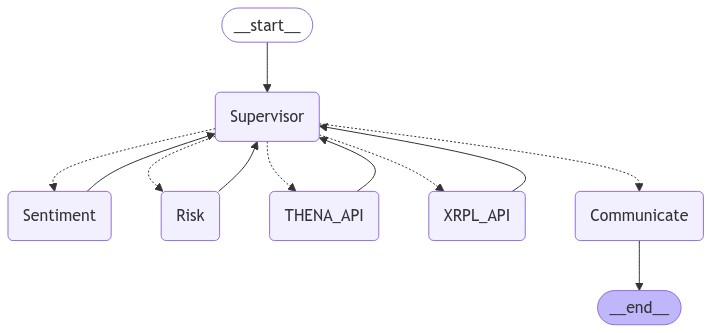

In [70]:
from functools import partial

workflow = StateGraph(AgentState)

# mem_node = partial(crew_nodes, crew_member=mem_agent, name="Memory")
sentiment_node = partial(crew_nodes, crew_member=sentiment_agent, name="Sentiment")
risk_node = partial(crew_nodes, crew_member=risk_agent, name="Risk")
thena_api_node = partial(crew_nodes, crew_member=thena_api_agent, name="THENA_API")
xrpl_api_node = partial(crew_nodes, crew_member=xrpl_api_agent, name="XRPL_API")

# workflow.add_node("Mem", mem_node)
workflow.add_node("Sentiment", sentiment_node)
workflow.add_node("Risk", risk_node)
workflow.add_node("THENA_API", thena_api_node)
workflow.add_node("XRPL_API", xrpl_api_node)
workflow.add_node("Communicate", comms_node )
workflow.add_node("Supervisor", supervisor_chain)
workflow.set_entry_point("Supervisor")
# workflow.add_edge('Mem', "Supervisor")
workflow.add_edge('Sentiment', "Supervisor")
workflow.add_edge('Risk', "Supervisor")
workflow.add_edge('THENA_API', "Supervisor")
workflow.add_edge('XRPL_API', "Supervisor")
workflow.add_edge('Communicate', END) 
# end loop at communication agent.

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], member_options)

graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Tests / Examples

Note: We still have a few error outputs to resolve, likely due to formatting issues of content returned to the model by the tools. 
This can be ignored for now, as the model is still able to generate responses. If we were to deploy this with a chat interface the issues can be masked.
Also, due to token limits, the model may not be able to generate as comprehensive responses as expected. 
This can be resolved by using a larger model or breaking down the query into smaller chunks to be repeated.

Please scroll all the way down to see generated responses or expand the cell in a new tab to see the full output.

In [73]:
from langchain_core.messages import HumanMessage

# Specify a thread
config = {"configurable": {"thread_id": "1"}}

messages = [
    HumanMessage(content="Can you suggest a few trustworthy investments on XRPL based on news and scores?")
]

# input_message = {"type": "user", "content": "hi! I'm bob"}
for chunk in graph.stream({"messages": messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you suggest a few trustworthy investments on XRPL based on news and scores?


OutputParserException: Invalid json output: ##  Solocoin's Fundamental Analysis on XRPL:

**Solocoin (SOLO)** is a community-driven meme coin on the XRPL that gained significant popularity and quickly reached a top 50 position on CoinMarketCap soon after its launch.

**Fundamental Analysis:**

*   **Tokenomics:** SOLO has a total supply of 1 trillion tokens, with 50% allocated to the public sale, 20% to the team, 15% to rewards, 10% to marketing, and 5% to liquidity. However, there have been concerns about the tokenomics being "centralized," as 23% of the solo coins were reportedly allocated to just five wallets.
*   **Use Case:** Currently, SOLO appears to be primarily a **speculative** asset without clearly defined use cases beyond being a meme coin. The SOLO network also offers features like token burning, which helps reduce token supply and potentially increase value. It has a low market cap and high 24h trading volume, implying potential for growth but also volatility.
*   **Community:** SOLO has a strong and enthusiastic community, which played a significant role in its initial popularity. 
*   **News and Media:**
    *   SOLO was listed on LATOKEN on March 18, 2023, which likely contributed to a slight price increase at that time.
    *   The SOLO ecosystem was reportedly in discussions with a Chinese consortium that may allow solocoin to be "incorporated into some Chinese enterprises and industries".
    *   The project had shown "great growth" and its price action showed "positive performance on the chart" during a May 2023 article.

**Potential Risks:**

*   **Lack of clear use case:** As with other meme coins, a lack of strong utility might hinder sustainable growth.
*   **Competition:** SOLO faces significant competition from well-established meme coins, such as DOGE and SHIB.
*   **Volatility:** As a young token, it experiences large price swings, leading to potential losses for investors.
*   **Centralization Concerns:** The significant share of tokens held by few wallets might raise questions about decentralization.

**Overall:**

Based on the fundamental analysis, SOLO shows potential for growth, but also carries notable risks. It's crucial to understand the project's limitations, conduct in-depth research, and consider your risk tolerance before making any investment decisions.

**Additional Resources:**

*   [SOLO Price Live](https://coinmarketcap.com/currencies/solocoin/)
*   [SOLO Project Links](https://solocoin.io/#links)
*   [SOLO Official Twitter](https://twitter.com/solocoinofficial)
*   [Solocoin News](https://www.newsbtc.com/tag/solocoin/)

**Disclaimer:** This is not financial advice, and the information presented should not be considered as such. Always do your own research before investing in any cryptocurrency.

From the above, we can see that the supervising agent knows to delegate tasks appropriately as there was risk analysis and fundamental analysis. We can also see that the worker agents are able to use the tools provided to do web search and query ripple ledger for content such as what coins are available on the ledger (in this case SOLOCOIN is one of them, more would have been suggested if there was no output token limit). We can also see that the model knows to perform a second call to specific token (SOLOCOIN) to get more information about it such as its dscription and associated resources.

Other questions that can be asked, examples are:
- “Perform a due diligence on token issuers and tell me about the trustworthiness of solocoin”
- “Search the internet on tweets of key opinion leaders about their sentiment on dogecoin”
- “Fetch for me the market activity of Ripple in the past 24 hours” -> “why should I invest, at what price point, and for how long should I hold this position?”
